In [ ]:
import os
import re
import numpy as np
import scipy.io as sio
from glob import glob

def load_one(file_path, V_rms):
    if not os.path.exists(file_path):
        raise FileNotFoundError(file_path)

    # --- extract metadata from filename ---
    fname = os.path.basename(file_path)
    # Example: sweep_50_500K_9000_1v_t10920_25.8.mat
    m = re.match(r"sweep_(\d+)_([\d\.]+)K_\d+_([\d\.]+)v_t(\d+)_([\d\.]+)\.mat", fname)
    if not m:
        raise ValueError(f"Unexpected filename format: {fname}")
    start_freq = float(m.group(1))
    stop_freq = float(m.group(2)) * 1e3  # convert K→Hz
    stim_voltage = float(m.group(3))
    weight = float(m.group(4)) / 100      # 10920 → 109.20 g
    temperature = float(m.group(5))


    # --- load .mat ---
    S = sio.loadmat(file_path, squeeze_me=True, struct_as_record=False)
    fn = [k for k in S.keys() if not k.startswith("__")]
    dev = getattr(S[fn[0]], "demods", None)
    if dev is None or not hasattr(dev, "sample"):
        raise KeyError(f"No dev.demods.sample in {file_path}")

    s = dev.sample
    if isinstance(s, (list, np.ndarray)) and len(s) > 0:
        s = s[0]

    f = np.array(s.frequency, dtype=float)
    X = np.array(s.x, dtype=float)
    Y = np.array(s.y, dtype=float)

    # Filter finite values in frequency range
    # mask = np.isfinite(f) & np.isfinite(X) & np.isfinite(Y)
    # f, X, Y = f[mask], X[mask], Y[mask]
    # mask = (f >= F_MIN) & (f <= F_MAX)
    # f, X, Y = f[mask], X[mask], Y[mask]

    # Complex current and impedance
    I = X + 1j * Y
    I_mag = np.abs(I)
    epsI = max(np.max(I_mag) * 1e-12, 1e-18)
    I[I_mag < epsI] = epsI

    Z = V_rms / I
    R = np.real(Z)
    Xc = np.imag(Z)
    Zmag = np.abs(Z)
    Zphase = np.degrees(np.angle(Z))

    return {
        "file": file_path,
        "f": f,
        "R": R,
        "Xc": Xc,
        "Zmag": Zmag,
        "Zphase": Zphase,
        "weight_g": weight,
        "temperature_C": temperature,
        "V_rms": V_rms,
        "start_freq": start_freq,
        "stop_freq": stop_freq,
        "stim_voltage": stim_voltage,
    }

# Example usage
data_dir = r"C:\Users\adres\OneDrive - Aarhus universitet\Thesis\Datasets\Mehdi_Dataset\Datafolder"
files = glob(os.path.join(data_dir, "*.mat"))

datasets = [
    load_one(f, V_rms=1.0)
    for f in files
]


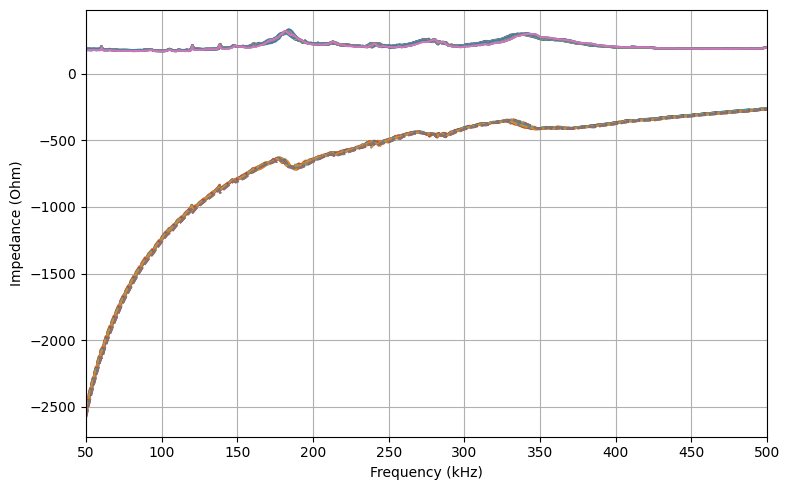

In [48]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
for d in datasets:
    label = f"{d['temperature_C']}°C, {d['weight_g']:.2f}g"
    plt.plot(d["f"] / 1000, d["R"], label=f"R - {label}", alpha=0.8)
    plt.plot(d["f"] / 1000, d["Xc"], linestyle="--", label=f"Xc - {label}", alpha=0.8)

plt.xlim(50, 500)
#plt.xlim(150, 200)
plt.xlabel("Frequency (kHz)")
plt.ylabel("Impedance (Ohm)")
#plt.legend(fontsize=8)
plt.grid(True)
plt.tight_layout()
plt.show()


# ML Pipeline

## 1. Data prep

In [49]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader

# Build dataset matrix
freqs = datasets[0]["f"]
X_data, y_data = [], []

for d in datasets:
    R = d["R"]
    Xc = d["Xc"]
    temp = d["temperature_C"]
    # feature vector: concatenate R, Xc, and temp
    features = np.concatenate([R, Xc, [temp]])
    X_data.append(features)
    y_data.append(d["weight_g"] - 115.0)  # target: delta weight

X_data = np.array(X_data, dtype=np.float32)
y_data = np.array(y_data, dtype=np.float32).reshape(-1, 1)


## 2. Pytorch dataset

In [50]:
class ImpedanceDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

dataset = ImpedanceDataset(X_data, y_data)


## 3. Train/Validate split

In [51]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, test_size=0.2, random_state=42)
train_ds = ImpedanceDataset(X_train, y_train)
val_ds = ImpedanceDataset(X_val, y_val)
train_loader = DataLoader(train_ds, batch_size=8, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=8)


## 4. Define model

In [52]:
import torch.nn as nn

class ImpedanceNet(nn.Module):
    def __init__(self, input_dim, hidden_channels, kernel_size, dropout):
        super().__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv1d(1, hidden_channels, kernel_size, padding=kernel_size//2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Conv1d(hidden_channels, hidden_channels*2, kernel_size, padding=kernel_size//2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Conv1d(hidden_channels*2, hidden_channels*4, kernel_size, padding=kernel_size//2),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        self.fc = nn.Linear(hidden_channels*4 * input_dim, 1)
        
    def forward(self, x):
        # x shape: (batch, features) -> (batch, 1, features)
        x = x.unsqueeze(1)
        x = self.conv_layers(x)
        x = x.flatten(1)
        return self.fc(x)


## 5. Optuna hyperparam search

In [53]:
import optuna

def objective(trial):
    hidden_channels = trial.suggest_int("hidden_channels", 8, 64)
    kernel_size = trial.suggest_int("kernel_size", 3, 9, step=2)
    dropout = trial.suggest_float("dropout", 0.0, 0.5)
    lr = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
    epochs = 100

    model = ImpedanceNet(X_train.shape[1], hidden_channels, kernel_size, dropout)
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()

    for epoch in range(epochs):
        model.train()
        for xb, yb in train_loader:
            pred = model(xb)
            loss = loss_fn(pred, yb)
            opt.zero_grad()
            loss.backward()
            opt.step()

    # validation loss
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for xb, yb in val_loader:
            pred = model(xb)
            val_loss += loss_fn(pred, yb).item()
    return val_loss / len(val_loader)

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=5)


[I 2025-10-21 12:13:39,045] A new study created in memory with name: no-name-cb50e6c6-edce-4441-a7b8-639158b54e4d
[I 2025-10-21 12:15:32,164] Trial 0 finished with value: 4654.68212890625 and parameters: {'hidden_channels': 20, 'kernel_size': 3, 'dropout': 0.42413611255248174, 'lr': 0.0005204249228946794}. Best is trial 0 with value: 4654.68212890625.
[I 2025-10-21 12:15:32,164] Trial 0 finished with value: 4654.68212890625 and parameters: {'hidden_channels': 20, 'kernel_size': 3, 'dropout': 0.42413611255248174, 'lr': 0.0005204249228946794}. Best is trial 0 with value: 4654.68212890625.
[I 2025-10-21 12:17:25,571] Trial 1 finished with value: 2.606856346130371 and parameters: {'hidden_channels': 18, 'kernel_size': 9, 'dropout': 0.4118014358422435, 'lr': 0.006937730458326272}. Best is trial 1 with value: 2.606856346130371.
[I 2025-10-21 12:17:25,571] Trial 1 finished with value: 2.606856346130371 and parameters: {'hidden_channels': 18, 'kernel_size': 9, 'dropout': 0.4118014358422435, 'l

## 6. Train final model with best parameters

In [54]:
best_params = study.best_params
model = ImpedanceNet(X_train.shape[1], best_params["hidden_channels"], best_params["kernel_size"], best_params["dropout"])
opt = torch.optim.Adam(model.parameters(), lr=best_params["lr"])
loss_fn = nn.MSELoss()

for epoch in range(200):
    model.train()
    for xb, yb in train_loader:
        opt.zero_grad()
        loss = loss_fn(model(xb), yb)
        loss.backward()
        opt.step()


## 7. Evaluate

In [55]:
model.eval()
with torch.no_grad():
    preds = model(torch.tensor(X_val))
    mse = ((preds - torch.tensor(y_val))**2).mean().item()
print(f"Validation MSE: {mse:.4f}")


Validation MSE: 8.3370


## 8. Plot predictions

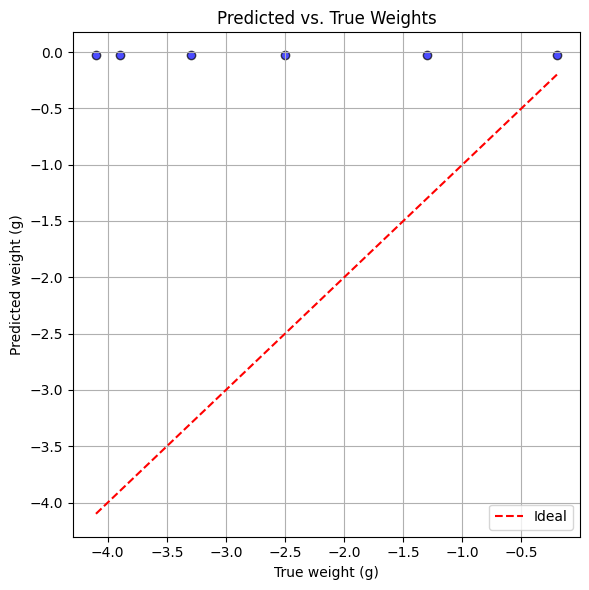

In [56]:
import matplotlib.pyplot as plt
import torch

model.eval()
with torch.no_grad():
    y_pred = model(torch.tensor(X_val, dtype=torch.float32)).squeeze().numpy()
    y_true = y_val.squeeze()

plt.figure(figsize=(6, 6))
plt.scatter(y_true, y_pred, c="blue", alpha=0.7, edgecolors="k")
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], "r--", label="Ideal")
plt.xlabel("True weight (g)")
plt.ylabel("Predicted weight (g)")
plt.title("Predicted vs. True Weights")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
